# Imports 

In [2]:
import kagglehub
from requests.exceptions import ChunkedEncodingError
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage import exposure
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pickle
from sklearn.decomposition import PCA
import seaborn as sns

/home/user_stel/image_assignment_2/image_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 

In [8]:
import os
os.environ["KAGGLEHUB_CACHE"] = "/home/user_stel/image_assignment_2/data/data_cache"
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Downloaded dataset to:", path)


100%|██████████| 2.29G/2.29G [07:52<00:00, 5.22MB/s]

Extracting files...


Downloaded dataset to: /home/user_stel/image_assignment_2/data/data_cache/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
BASE_DIR = "/home/user_stel/image_assignment_2/data/data_cache/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

In [4]:
classes = ['NORMAL', 'PNEUMONIA']

# Preprocessing 

For the preprocessing part of this project 3 custom methods were created, one that handles all the preprocessing steps, one that iterates over all images in the respective directories and employes the preprocessing for each image and one that creates the final datasets, where classes are assigned. These are the preprocessing steps that the preprocess_image function performs for each image:
- Grayscale Transformation
- Resize-Reshape
- Normalization<br> 

In [ ]:
# Methods

def preprocess_image(img_path, img_size=(128, 128), normalize=True, save_path=None):
    """
    Loads and preprocesses a chest X-ray image:
        Converts to grayscale
        Resizes to (img_size)
        Normalizes pixel values to [0, 1] if normalize=True
        Optionally saves the preprocessed image

    Returns:
        np.ndarray: preprocessed image
    """
    # Load as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    
    # Resize
    img = cv2.resize(img, img_size)
    
    # Normalize
    if normalize:
        img = img.astype(np.float32) / 255.0

    # Optional save
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        img_to_save = (img * 255).astype(np.uint8) if normalize else img
        cv2.imwrite(save_path, img_to_save)

    return img

def preprocess(input_folder, output_folder, img_size=(128, 128), normalize=True):
    """
    Preprocess all images in a folder and save them to a new location.

    Parameters:
        input_folder (str): Root folder containing subfolders of images (e.g., 'NORMAL', 'PNEUMONIA').
        output_folder (str): Root folder where processed images will be saved.
        img_size (tuple): Target image size (width, height).
        normalize (bool): Whether to normalize pixel values to [0, 1].

    Returns:
        processed_paths (list): List of all saved image paths.
    """
    processed_paths = []

    for root, dirs, files in os.walk(input_folder):
        for filename in files:
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                # Build full input path
                img_path = os.path.join(root, filename)

                # Compute relative path and destination
                rel_path = os.path.relpath(img_path, input_folder)
                save_path = os.path.join(output_folder, rel_path)

                try:
                    preprocess_image(
                        img_path=img_path,
                        img_size=img_size,
                        normalize=normalize,
                        save_path=save_path
                    )
                    processed_paths.append(save_path)
                except Exception as e:
                    print(f"Failed to process {img_path}: {e}")

    return processed_paths

def load_dataset_from_folder(base_path, save_path=None):
    """
    Loads preprocessed images and assigns labels.
    Assumes 'NORMAL' → label 0, 'PNEUMONIA' → label 1.

    Parameters:
        base_path (str): Path to folder with subfolders 'NORMAL', 'PNEUMONIA'.
        img_size (tuple): Size to resize images to.
        save_path (str or None): If provided, saves X and y as a .npz file.

    Returns:
        X (np.ndarray): Image data, shape = (n_samples, height, width)
        y (np.ndarray): Labels, shape = (n_samples,)
    """
    X = []
    y = []

    class_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name, label_value in class_map.items():
        folder = os.path.join(base_path, label_name)
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                fpath = os.path.join(folder, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Could not load {fpath}")
                    continue

                img = img.astype("float32") / 255.0

                X.append(img)
                y.append(label_value)

    X = np.array(X)
    y = np.array(y)

    if save_path:
        np.savez(save_path, X=X, y=y)
        print(f"✅ Saved dataset to {save_path}")

    return X, y

### Preprocess Train Data 

In [ ]:
# normal train
input_folder = os.path.join(BASE_DIR, "train", "NORMAL")
output_folder = os.path.join(BASE_DIR, "preprocessed", "NORMAL")

# Preprocess all normal images from the train dataset 
# and save them into the preprocessed normal directory that 
# contains all the preprocessed normal images for training 
processed_files = preprocess(
    input_folder=input_folder,
    output_folder=output_folder,
    img_size=(128, 128),
    normalize=True
)

print(f"Processed {len(processed_files)} images.")

Processed 1341 images.


In [ ]:
# pneumonia train
input_folder = os.path.join(BASE_DIR, "train", "PNEUMONIA")
output_folder = os.path.join(BASE_DIR, "preprocessed", "PNEUMONIA")

# Preprocess all images from patients with pneumonia from the train dataset 
# and save them into the preprocessed pneumonia directory that 
# contains all the preprocessed pneumonia images for training 
processed_files = preprocess(
    input_folder=input_folder,
    output_folder=output_folder,
    img_size=(128, 128),
    normalize=True
)

print(f"Processed {len(processed_files)} images.")

Processed 3875 images.


### Preprocess Test Data

In [ ]:
# normal test
input_folder = os.path.join(BASE_DIR, "test", "NORMAL")
output_folder = os.path.join(BASE_DIR, "preprocessed_test", "NORMAL")

# Preprocess all normal images from the test dataset 
# and save them into the preprocessed test normal directory that 
# contains all the preprocessed normal images for testing 
processed_files = preprocess(
    input_folder=input_folder,
    output_folder=output_folder,
    img_size=(128, 128),
    normalize=True
)

print(f"Processed {len(processed_files)} images.")

Processed 234 images.


In [ ]:
# pneumonia test
input_folder = os.path.join(BASE_DIR, "test", "PNEUMONIA")
output_folder = os.path.join(BASE_DIR, "preprocessed_test", "PNEUMONIA")

# Preprocess all images from patients with pneumonia from the test dataset 
# and save them into the preprocessed test pneumonia directory that 
# contains all the preprocessed pneumonia images for testing 
processed_files = preprocess(
    input_folder=input_folder,
    output_folder=output_folder,
    img_size=(128, 128),
    normalize=True
)

print(f"Processed {len(processed_files)} images.")

Processed 390 images.


# Data for NN approach

In [7]:
# merge into a train dataset, normal images are assigned to class 0 
# and images from pneumonia patients are assigned to class 1
preprocessed_train_path = os.path.join(BASE_DIR, "preprocessed")
X_train, y_train = load_dataset_from_folder(base_path=preprocessed_train_path, save_path="train_data.npz")

preprocessed_test_path = os.path.join(BASE_DIR, "preprocessed_test")
X_test, y_test = load_dataset_from_folder(base_path=preprocessed_test_path, save_path="test_data.npz")

✅ Saved dataset to train_data.npz
✅ Saved dataset to test_data.npz


# Extract HOG Features for ML approach

In [5]:
def extract_hog_features(folder_path, label):
    data = []
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        data.append((features, label))
    return data


### Train Data for ML 

In [16]:
normal_path = os.path.join(BASE_DIR, "preprocessed", "NORMAL")
normal_train_data = extract_hog_features(normal_path, label=0)       # label 0 = NORMAL

In [17]:
pneumonia_path = os.path.join(BASE_DIR, "preprocessed", "PNEUMONIA")
pneumonia_train_data = extract_hog_features(pneumonia_path, label=1) # label 1 = PNEUMONIA

In [18]:
# merge into one dataset
train_data = normal_train_data + pneumonia_train_data

### Save Train data

In [ ]:
X_train, y_train = zip(*train_data)
X_train = np.array(X_train)
y_train = np.array(y_train)

with open("train_data.pkl", "wb") as f:
    pickle.dump(train_data, f)

# # in order to load stored data for training
# with open("train_data.pkl", "rb") as f:
#     train_data = pickle.load(f)

### Test Data for NN

In [13]:
normal_path = os.path.join(BASE_DIR, "preprocessed_test", "NORMAL")
normal_test_data = extract_hog_features(normal_path, label=0)       # label 0 = NORMAL

In [14]:
pneumonia_path = os.path.join(BASE_DIR, "preprocessed_test", "PNEUMONIA")
pneumonia_test_data = extract_hog_features(pneumonia_path, label=1) # label 1 = PNEUMONIA

In [15]:
# merge into one dataset
test_data = normal_test_data + pneumonia_test_data

### Save Test Data 

In [ ]:
X_test, y_test = zip(*test_data)
X_test = np.array(X_test)
y_test = np.array(y_test)

with open("test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)

# # in order to load stored data for training
# with open("test_data.pkl", "rb") as f:
#     test_data = pickle.load(f)

#### Zip data folder to save space

In [1]:
import shutil
import os

# Path to the folder you want to zip
folder_to_zip = os.path.join(os.getcwd(), "data")

# The name (and path) of the resulting archive (without extension)
archive_name = os.path.join(os.getcwd(), "data_archive")

# Create a ZIP archive
shutil.make_archive(base_name=archive_name, format='zip', root_dir=folder_to_zip)

print(f"Created archive: {archive_name}.zip")


Created archive: /home/user_stel/image_assignment_2/data_archive.zip


# Visualization

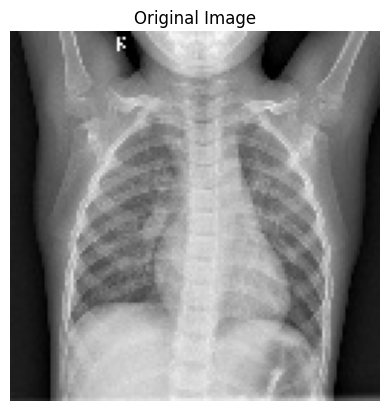

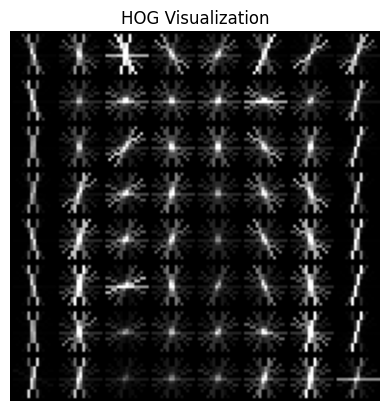

In [ ]:
img = cv2.imread('/home/user_stel/image_assignment_2/data/data_cache/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/preprocessed/NORMAL/IM-0115-0001.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

features, hog_image = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.show()

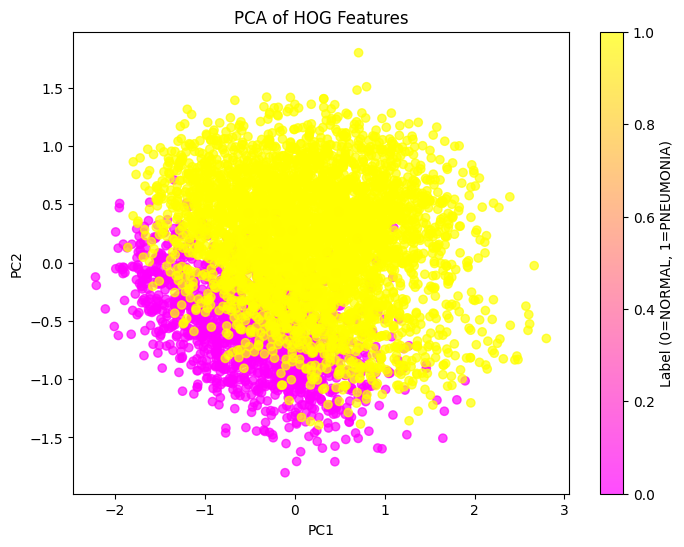

In [ ]:
# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='spring', alpha=0.7)
plt.title('PCA of HOG Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Label (0=NORMAL, 1=PNEUMONIA)')
plt.show()

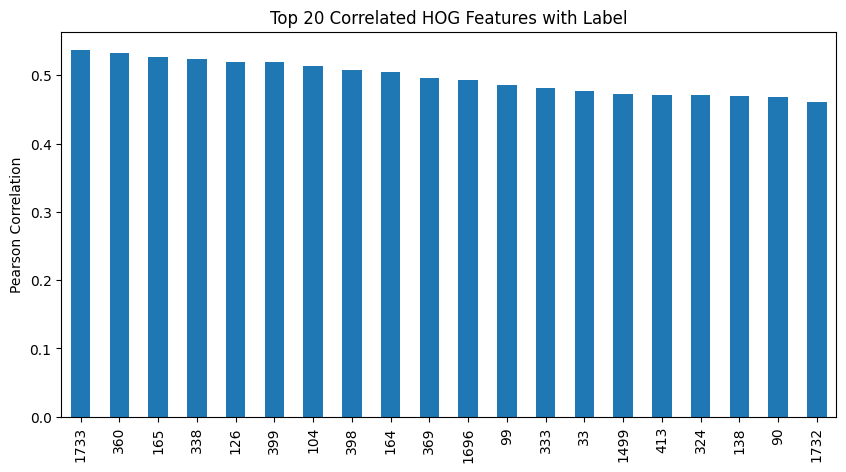

In [31]:
# Pearson correlation analysis between HOG fetaures and target 
import pandas as pd

# Convert to DataFrame for easier analysis
df = pd.DataFrame(X_train)
df['label'] = y_train

# Correlation of each feature with the label
correlations = df.corr()['label'][:-1]  # exclude the label-label correlation

# Plot top 20 correlated features
top_k = correlations.abs().sort_values(ascending=False)[:20]
top_k.plot(kind='bar', title='Top 20 Correlated HOG Features with Label', figsize=(10, 5))
plt.ylabel('Pearson Correlation')
plt.show()


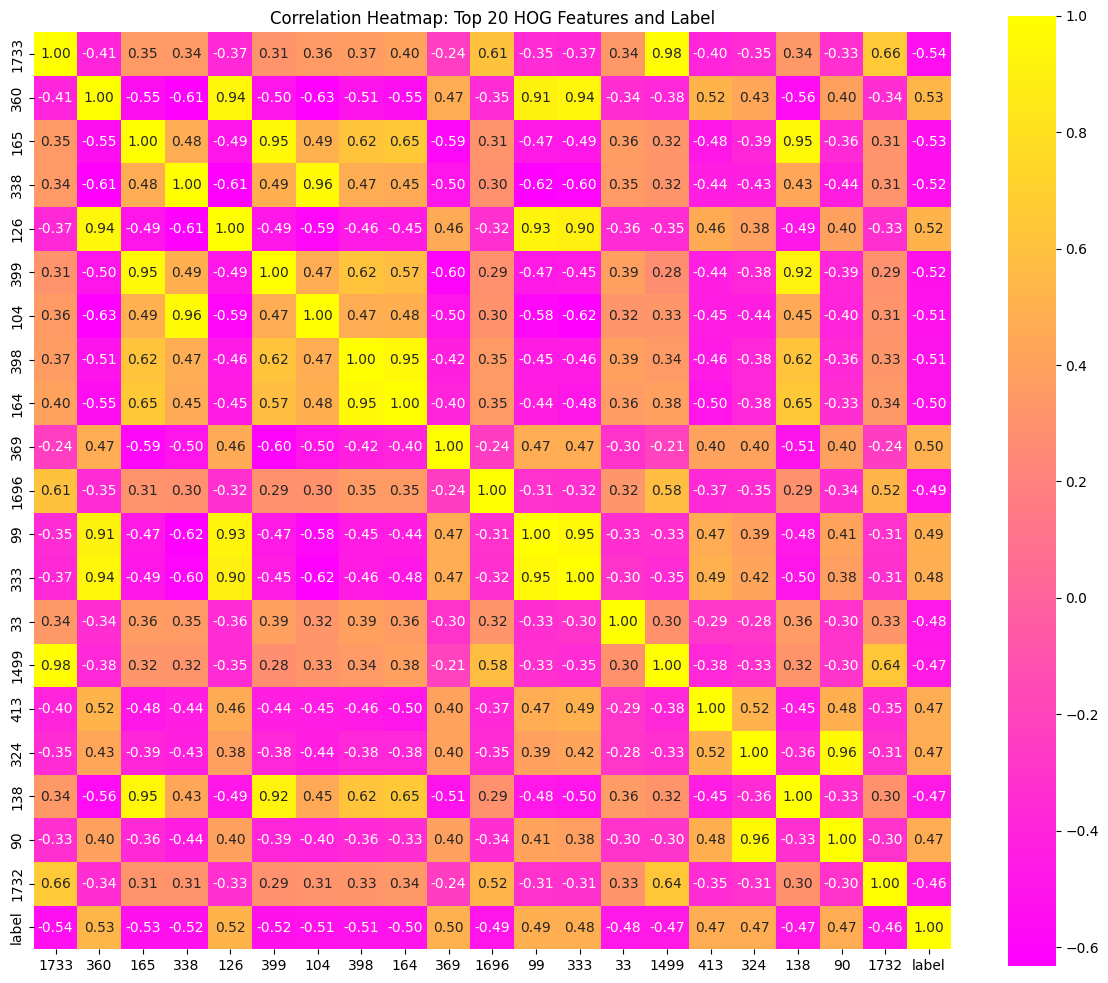

In [34]:
# Convert to DataFrame
df = pd.DataFrame(X_train)
df['label'] = y_train

# Compute full correlation matrix
corr_matrix = df.corr()

# Get top 20 features most correlated with the label (absolute value)
top_k_features = corr_matrix['label'].abs().sort_values(ascending=False).index[1:21]  # exclude 'label' itself

# Include 'label' in the heatmap
features_to_plot = list(top_k_features) + ['label']

# Slice the correlation matrix for these features
mini_corr_matrix = corr_matrix.loc[features_to_plot, features_to_plot]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mini_corr_matrix, annot=True, fmt=".2f", cmap='spring', square=True, cbar=True)
plt.title("Correlation Heatmap: Top 20 HOG Features and Label")
plt.tight_layout()
plt.show()